Make sure you fill in any place that says `YOUR CODE HERE`. 

---

# Homework 10 (Scheduling with Dependencies)

*This* is a Python Notebook homework.  It consists of various types of cells: 

* Text: you can read them :-) 
* Code: you should run them, as they may set up the problems that you are asked to solve.
* **Solution:** These are cells where you should enter a solution.  You will see a marker in these cells that indicates where your work should be inserted.  

```
    # YOUR CODE HERE
```    

* Test: These cells contains some tests, and are worth some points.  You should run the cells as a way to debug your code, and to see if you understood the question, and whether the output of your code is produced in the correct format.  The notebook contains both the tests you see, and some secret ones that you cannot see.  This prevents you from using the simple trick of hard-coding the desired output. 

### Working on Your Notebook

To work on your notebook: 

* Click on _File > Save a copy in Drive_ : this will create a copy of this file in your Google Drive; you will find the notebook in your _Colab Notebooks_ folder. 
* Work on that notebook.  Check that the runtime has GPUs (Runtime > Change Runtime Type, and check that GPU is selected).

### IMPORTANT

Please, in the cell below, define `colab = True`, so that you are able to run the problems on Google Colab.  The only reason I define it `False` here is that, when autograding, I do not want to run all the model fitting.  If you leave `colab` to be `False`, the notebook will not do anything interesting. 


### Submitting Your Notebook

Submit your work as follows: 

* Download the notebook from Colab, clicking on "File > Download .ipynb".
* Upload the resulting file to [this Google form](https://docs.google.com/forms/d/e/1FAIpQLScBxRKLT3yD4QMpgcLnwG64Ae5t10ePWyIJa4nUGF_d_zovuA/viewform?usp=sf_link).
* **Deadline: [see home page](https://sites.google.com/a/ucsc.edu/luca/classes/cse-30/cse-30-fall-2019)**

You can submit multiple times, and the last submittion before the deadline will be used to assign you a grade. 

Assume you have to prepare Pasta Carbonara.   A recipe could go like this: 

> Dice onions and pancetta, and fry in a mix of olive oil and butter, slowly.  Separately, put in a bowl as many eggs as there are dinner guests; you can either put in the bowls the yolks only, or you can add a few whites if you wish.  Beat the eggs.  
> Bring water to a boil, and when it boils, salt it.  Put the pasta in (I like Penne Rigate).   When cooked, colander the water away, and quickly unite in the bowl the beaten eggs, the pasta, and the pancetta.  Mix well and serve immediately. 

If you have to invite people over, you could do this recipe sequentially, and first worry about cooking the pasta: warming the water, putting the pasta in, then colandering it.  Then you could worry about cooking the pancetta and onions.  When that's done, you can start to beat the eggs. Finally, you could unite everything.  Technically, that would work, but there would be two problems.  The first is that, of course, the pasta would be rather cold by the time it would be served, a capital sin (pasta must be served immediately after it is cooked).  Secondly, even if you rehash the order so that you first cook the pancetta, then beat the eggs, then cook the pasta, then technically this works -- but it would take you well over one hour to have everything ready.  You want to do things in parallel, cooking the pancetta while heating up the water for the pasta, and so forth.  You want to discover what are the things that need to be done one after the other, and what are the things that can be done in parallel, and in which order to do everything.  

Great cooking, by the way, is much about the perfect timing, not only the perfect preparation.  You have to have the various preparations ready at the same time, to unite them just right.  We will worry about timing in the second part of this chapter; first, we worry about what we can do and in which order.

As an aside for those of you who are more interested in compiling code than in cooking, the problem of how to compile C or C++ code is very similar.  A makefile defines dependencies between tasks: you have to have compiled pathlib.c before you can link the result together with something else.  The task of the make program is to figure out how to parallelize the compilation, so that independent tasks can happen in different processes (possibly on different CPU cores), while respecting the precedence constraints between tasks.  We will mention this application in some of the exercises of the chapter. 





## Scheduling dependent tasks

We first disregard the problem of cooking (or compiling) time, and ask about the order in which we should be doing the tasks.  We want to create a _Scheduler_ object, that can tell us what to do at the same time.  What operations should this object support? 

* **add_task:** we should be able to add a task, along with the task dependencies. 
* **reset:** indicating that we are about to run the sequences of tasks again.
* **get_tasks:** this should return the set of things that we can do in parallel. 
* **completed:** used to notify the scheduler that we have completed a task.  This should return the set of new tasks that we can do due to this task being completed; we can do these tasks in parallel alongside with the others that we are already doing. 
* **all_done:** returns True/False according to whether we have completed all tasks. 

Choosing these operations is perhaps the most important step in the design of the scheduler.  The operations need to have a simple, clear definition, and be useful in a concrete implementation of the service which will run the tasks.  Of the above operations, they are all uncontroversial, except for the choice of behavior of _completed_.  In theory, there is no need for _completed_ to return the set of _new_ tasks that can now be undertaken.  If one remembers the set of tasks $T_1$ one can a do before a task $t \in T_1$ is completed, and marks $t$ as completed, one can simply ask the scheduler for the set of tasks $T_2$ that can now be done, and add those in $T_{21t} = T_2 \setminus (\{t\} \cup T_1)$ for execution.  However, we guess (as we have not yet written the task execution engine) that being told this set of tasks directly will simplify the design of the task execution engine. 

Our scheduler class will be implemented in similar fashion to our graph class, with tasks corresponding to graph vertices, and dependencies represented as edges.
The difference is that here, given a vertex (that is, a task) $v$, it will be useful to be able to access both:

* the _predecessors_ of $v$, that is, the tasks $u$ that are declared as prerequisites of $v$, and 
* the _successors_ of $v$, that is, the tasks $u$ such that $v$ was declared as a prerequisite for $u$. 

When we add a task, we would have to initialize its set of successors and predecessors to empty.  This is somewhat tedious, and so we resort to a defaultdict, which is a special type of dictionary such that, if the mapping for a key has not been defined, it returns a default value; in our case, an empty set.  [You can read more about defaultdict and related types here](https://docs.python.org/3.7/library/collections.html#collections.defaultdict). 

Our first implementation of the class is as follows. 


In [0]:
from collections import defaultdict
import networkx as nx # Library for displaying graphs.
import matplotlib.pyplot as plt

class DependencyScheduler(object):
    
    def __init__(self):
        self.tasks = set()
        # The successors of a task are the tasks that depend on it, and can
        # only be done once the task is completed.
        self.successors = defaultdict(set)
        # The predecessors of a task have to be done before the task.
        self.predecessors = defaultdict(set)
        self.completed_tasks = set() # completed tasks
        
    def add_task(self, t, dependencies):
        """Adds a task t with given dependencies."""
        # Makes sure we know about all tasks mentioned.
        self.tasks.add(t)
        self.tasks.update(dependencies)
        # The predecessors are the tasks that need to be done before. 
        self.predecessors[t] = set(dependencies)
        # The new task is a successor of its dependencies. 
        for u in dependencies:
            self.successors[u].add(t)

    def reset(self):
        self.completed_tasks = set()
        
    @property
    def done(self):
        return self.completed_tasks == self.tasks
    
    @property
    def available_tasks(self):
        """Returns the set of tasks that can be done in parallel.
        A task can be done if all its predecessors have been completed.
        And of course, we don't return any task that has already been
        completed."""
        # It's just too nice to be able to do this with a one-liner. 
        return ({t for t in self.tasks 
                 if self.predecessors[t].issubset(self.completed_tasks)}
                - self.completed_tasks)
        
    def mark_completed(self, t):
        """Marks the task t as completed, and returns the additional 
        set of tasks that can be done (and that could not be 
        previously done) once t is completed."""
        self.completed_tasks.add(t)
        return {u for u in self.successors[t] 
                if self.predecessors[u].issubset(self.completed_tasks)}
    
    def show(self):
        """We use the nx graph to display the graph."""
        g = nx.DiGraph()
        g.add_nodes_from(self.tasks)
        g.add_edges_from([(u, v) for u in self.tasks for v in self.successors[u]])
        node_colors = ''.join([('g' if v in self.completed_tasks else 'r')
                           for v in self.tasks])
        nx.draw(g, with_labels=True, node_color=node_colors)
        plt.show()

    @property
    def uncompleted(self):
        """Returns the tasks that have not been completed.
        This is a property, so you can say scheduler.uncompleted rather than
        scheduler.uncompleted()"""
        return self.tasks - self.completed_tasks
    
    def _check(self):
        """We check that if t is a successor of u, then u is a predecessor 
        of t."""
        for u in self.tasks:
            for t in self.successors[u]:
                assert u in self.predecessors[t]

Let us check if this works.

In [0]:
# Let us ensure that nose is installed. 
try:
    from nose.tools import assert_equal, assert_true
    from nose.tools import assert_false, assert_almost_equal
except:
    !pip install nose
    from nose.tools import assert_equal, assert_true
    from nose.tools import assert_false, assert_almost_equal

     |████████████████████████████████| 163kB 9.7MB/s 


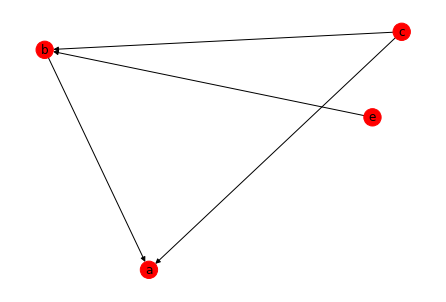

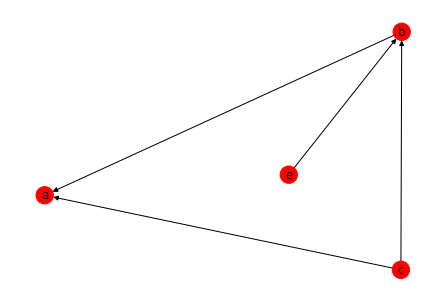

In [0]:
from nose.tools import assert_true, assert_false, assert_equal

s = DependencyScheduler()
s.add_task('a', ['b', 'c'])
s.add_task('b', ['c', 'e'])
s._check()
s.show()

We note that in the above drawing, the edges denote temporal succession, that is, an edge from $c$ to $a$ means that $c$ must happen before $a$. 
Let us execute the schedule manually.

In [0]:
import random

def execute_schedule(s, show=False):
    s.reset()
    in_process = s.available_tasks
    print("Starting by doing:", in_process)
    while len(in_process) > 0:
        # Picks one random task to be the first to be completed.
        t = random.choice(list(in_process))
        print("Completed:", t)
        in_process = in_process - {t} | s.mark_completed(t)
        print("Now doing:", in_process)
        if show:
            s.show()
    # Have we done all? 
    if not s.done:
        print("Error, there are tasks that could not be completed:", s.uncompleted)

Starting by doing: {'e', 'c'}
Completed: c
Now doing: {'e'}


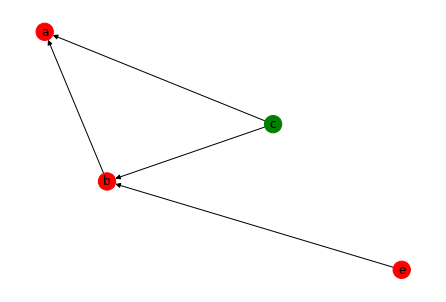

Completed: e
Now doing: {'b'}


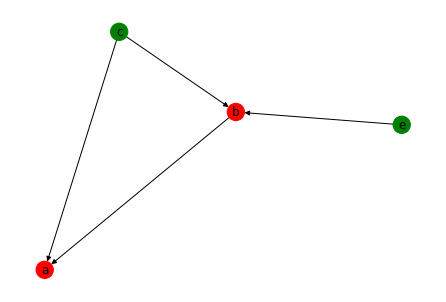

Completed: b
Now doing: {'a'}


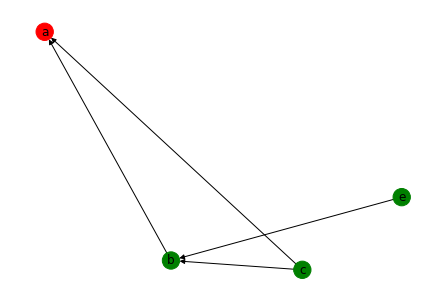

Completed: a
Now doing: set()


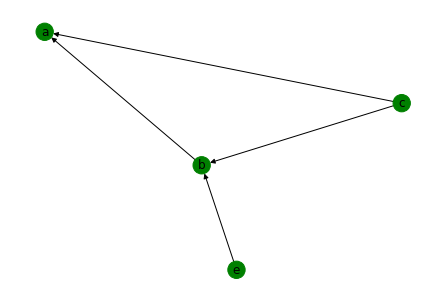

Starting by doing: {'e', 'c'}
Completed: e
Now doing: {'c'}


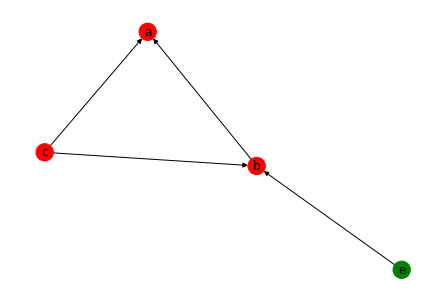

Completed: c
Now doing: {'b'}


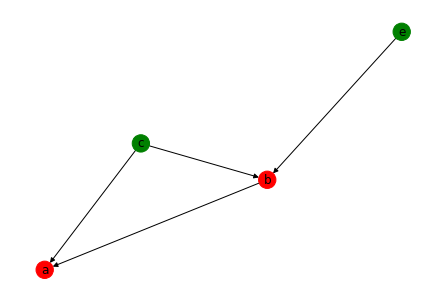

Completed: b
Now doing: {'a'}


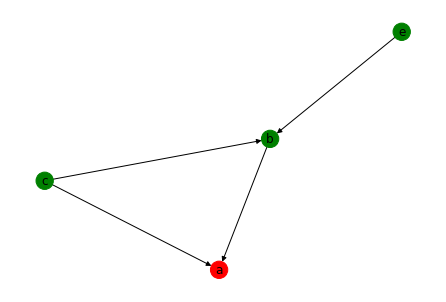

Completed: a
Now doing: set()


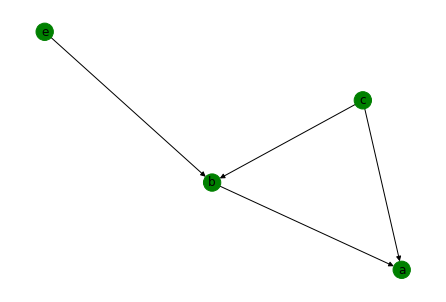

In [0]:
execute_schedule(s, show=True)

What happens if there is a loop? 

In [0]:
s = DependencyScheduler()
s.add_task('a', ['b'])
s.add_task('b', ['a'])
s.add_task('c', ['a'])
execute_schedule(s)

Starting by doing: set()
Error, there are tasks that could not be completed: {'a', 'b', 'c'}
Starting by doing: set()
Error, there are tasks that could not be completed: {'a', 'b', 'c'}


Ok, this is reasonable!  Let us now encode our Carbonara pasta recipe. 

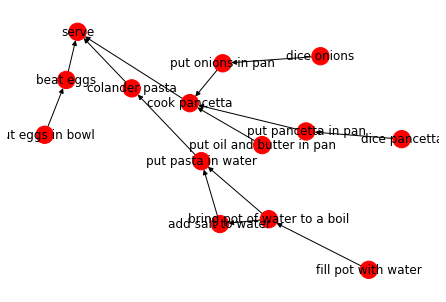

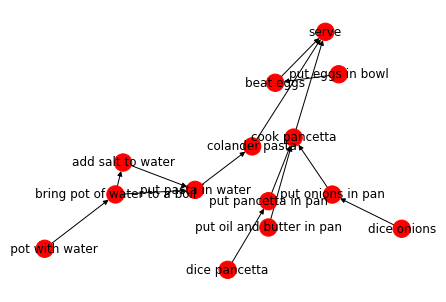

In [0]:
carbonara = DependencyScheduler()

# First, the part about cooking the pancetta. 
carbonara.add_task('dice onions', [])
carbonara.add_task('dice pancetta', [])
carbonara.add_task('put oil and butter in pan', [])
carbonara.add_task('put pancetta in pan', ['dice pancetta'])
carbonara.add_task('put onions in pan', ['dice onions'])
carbonara.add_task('cook pancetta', ['put oil and butter in pan', 
                                     'put pancetta in pan', 
                                     'put onions in pan'])

# Second, the part about beating the eggs. 
carbonara.add_task('put eggs in bowl', [])
carbonara.add_task('beat eggs', ['put eggs in bowl'])

# Third, cooking the pasta. 
carbonara.add_task('fill pot with water', [])
carbonara.add_task('bring pot of water to a boil', ['fill pot with water'])
carbonara.add_task('add salt to water', ['bring pot of water to a boil'])
carbonara.add_task('put pasta in water', ['bring pot of water to a boil',
                                         'add salt to water'])
carbonara.add_task('colander pasta', ['put pasta in water'])

# And finally, we can put everything together.
carbonara.add_task('serve', ['beat eggs', 'cook pancetta', 'colander pasta'])

# Let's look at our schedule!
carbonara.show()

In [0]:
# And let's finally prepare carbonara!
execute_schedule(carbonara)

Starting by doing: {'fill pot with water', 'dice onions', 'put oil and butter in pan', 'put eggs in bowl', 'dice pancetta'}
Completed: fill pot with water
Now doing: {'dice onions', 'put oil and butter in pan', 'put eggs in bowl', 'bring pot of water to a boil', 'dice pancetta'}
Completed: put oil and butter in pan
Now doing: {'bring pot of water to a boil', 'dice onions', 'dice pancetta', 'put eggs in bowl'}
Completed: dice pancetta
Now doing: {'put pancetta in pan', 'bring pot of water to a boil', 'dice onions', 'put eggs in bowl'}
Completed: dice onions
Now doing: {'put onions in pan', 'bring pot of water to a boil', 'put pancetta in pan', 'put eggs in bowl'}
Completed: put pancetta in pan
Now doing: {'put onions in pan', 'bring pot of water to a boil', 'put eggs in bowl'}
Completed: put onions in pan
Now doing: {'bring pot of water to a boil', 'cook pancetta', 'put eggs in bowl'}
Completed: put eggs in bowl
Now doing: {'bring pot of water to a boil', 'cook pancetta', 'beat eggs'}
C

It doesn't make much sense as a logical order in which to prepare pasta carbonara, but it definitely works as a schedule.

**Exercise:** Raise an `IllegalCompletion` exception if a task is marked completed via a `completed` call, and yet, not all of its prerequisites had been completed.

In [0]:
### Checks that `mark_completed` does not mark completed a task whose prerequisites are not all done

class IllegalCompletion(Exception):    
    def __init__(self, t):
        self.message = "Not all prerequisited for %r have been completed" % t


def dependency_scheduler_mark_completed(self, t):
    """Marks the task t as completed, and returns the additional 
    set of tasks that can be done (and that could not be 
    previously done) once t is completed."""
    # Insert the check below.
    # YOUR CODE HERE
    if (self.predecessors[t].issubset(self.completed_tasks)) == False:
        raise IllegalCompletion(t)
    self.completed_tasks.add(t)
    return {u for u in self.successors[t] 
            if self.predecessors[u].issubset(self.completed_tasks)}

DependencyScheduler.mark_completed = dependency_scheduler_mark_completed

Let us test this.

In [0]:
### Tests for `mark_completed` checks

s = DependencyScheduler()
s.add_task('a', [])
s.add_task('b', ['a'])
s.add_task('c', ['a'])
s.add_task('d', ['b', 'c'])
s.add_task('e', ['a', 'd'])

s.mark_completed('a')
s.mark_completed('b')
raised = False
try:
    s.mark_completed('d')
except IllegalCompletion:
    raised = True
assert_true(raised)


### Execution Engine

Let us build a better execution engine for our schedules.  Right now, we have a function:

In [0]:
def execute_schedule(s, show=False):
    s.reset()
    in_process = s.available_tasks
    print("Starting by doing:", in_process)
    while len(in_process) > 0:
        # Picks one random task to be the first to be completed.
        t = random.choice(list(in_process))
        print("Completed:", t)
        in_process = in_process - {t} | s.mark_completed(t)
        print("Now doing:", in_process)
        if show:
            s.show()
    # Have we done all? 
    if not s.done:
        print("Error, there are tasks that could not be completed:", s.uncompleted)

We want to wrap these methods into a class, RunSchedule.  This will allow us more flexibility in executing a schedule, as we will be able to specify parameters that guide the execution policy, interrupt and resume the execution, and so on.  
An object of class RunSchedule is initialized with a DependencyScheduler.  It then has the following methods: 

* **reset:** mark all tasks as not completed. 
* **step:** perform one step in the schedule, completing a single task.
* **run:** performs all steps in the schedule, until completion. 
* **done:** indicates that all tasks have been done.

What should these methods return?  _step_ will return the task executed, while _run_ will return the whole list of tasks, in the order in which they were done. 

In [0]:
class RunSchedule(object):
    
    def __init__(self, scheduler):
        self.scheduler = scheduler
        self.in_process = None # Indicating, we don't know yet.
        
    def reset(self):
        self.scheduler.reset()
        self.in_process = None
        
    def step(self):
        """Performs a step, returning the task, if any, or None, 
        if there is no step that can be done."""
        # If we don't know what steps are in process, we get them.
        if self.in_process is None:
            self.in_process = self.scheduler.available_tasks
        if len(self.in_process) == 0:
            return None
        t = random.choice(list(self.in_process))
        self.in_process = self.in_process - {t} | self.scheduler.mark_completed(t)
        return t
    
    @property
    def done(self):
        return self.scheduler.done
    
    def run(self):
        """Runs the scheduler from the current configuration to completion.
        You must call reset() first, if you want to run the whole schedule."""
        tasks = []
        while not self.done:
            t = self.step()
            if t is not None:
                tasks.append(t)
        return tasks

We can run our pasta carbonara with this RunSchedule class:

In [0]:
runner = RunSchedule(carbonara)
runner.reset()
runner.run()

['put oil and butter in pan',
 'dice onions',
 'put onions in pan',
 'dice pancetta',
 'fill pot with water',
 'put eggs in bowl',
 'beat eggs',
 'bring pot of water to a boil',
 'add salt to water',
 'put pasta in water',
 'put pancetta in pan',
 'colander pasta',
 'cook pancetta',
 'serve']

['put oil and butter in pan',
 'dice pancetta',
 'put pancetta in pan',
 'put eggs in bowl',
 'beat eggs',
 'fill pot with water',
 'dice onions',
 'bring pot of water to a boil',
 'add salt to water',
 'put onions in pan',
 'put pasta in water',
 'cook pancetta',
 'colander pasta',
 'serve']

Let us pause for a moment and ask: did we really need to create a new class? Could we not have done the above in the scheduler class? 

This is debatable.  The idea in keeping the two classes separate is clarity of goals: 

* The scheduler is concerned with what _can_ be done next. 
* The runner is concerned with any practical constraint to the execution, and with the choice of _what_, among the possible, is actually done. 

We will have occasion below to rely on this division of concerns.

### Code changes and rotten eggs

#### Code changes

Suppose you are cooking pasta carbonara, but you realize too late that the eggs are rotten.  What steps should you repeat? 

Well, in the case of pasta alla carbonara, I am afraid to say, if you have already united the eggs with the other ingredients, you may be out of luck: you have to redo everything from scratch.  Indeed, we will look in a later exercise at how to cope with the mishap -- or better, disaster.   But a similar situation  is of interest in compiling compute code.  Imagine that you need to compile three programs, $a$, $c$, and then link together the results into $f.out$.   Once this is done, you compile $d$ and $e$, and link into $g.out$.  As the last step, you link the two libraries $g.out$ and $f.out$ together, and produce $h$. You do it once.  Great.  But now you realize that you need to change $b$.  Do you have to start from scratch? 

You may think, who cares, it's the CPU doing the work, not me.  Fair enough, but there are some large systems that take minutes, dozen of minutes, to compile.  If you are compiling the linux kernel on a low power CPU, it might take hours.  Surely you don't want to redo everything from scratch!  

So imagine you have the tasks in an intermediate state, with some being completed (possibly all of them), and some not.  You can now mark one of the tasks as incomplete, to signal you need to do it again.  What is the set of tasks that as a consequence should also be marked incomplete? 
If you have two tasks $x$ and $y$, with $y$ being a successor to $x$, if $x$ is marked as "undone" as it needs to be redone, then also $y$ will need to be redone, as it might use the results of $x$.

To implement this, we will perform two modifications.  First, we will endow our scheduler with a _redo_ method, which marks a task and all its successors to be redone.  We let you implement this; you have already seen how to compute reachability in the graph chapter. 


In [0]:
### Implementation of `redo`

def dependency_scheduler_redo(self, t):
    """Mark the task t, and all its successors, as undone.
    Returns the set of successor tasks of t, with t included."""
    # YOUR CODE HERE
    result_set = set() #successor tasks of t, with t included
    def redo_recurs(t):
        if t in self.completed_tasks: #mark t as incomplete
            self.completed_tasks.remove(t)
        result_set.add(t)
        for a in self.successors[t]: #loop through the successors of t
            if len(self.successors[a]) == 0: #if a successor of t has no successors itself, mark it as incomplete instantly
                if a in self.completed_tasks:
                    self.completed_tasks.remove(a) 
                result_set.add(a)
            else: #if a successor of t has successors, recursively loop through its successors by calling this recursion method, inputting a as t
               redo_recurs(a)
    redo_recurs(t) 
    return result_set

DependencyScheduler.redo = dependency_scheduler_redo

Let us test the implementation.

In [0]:
### Tests for `redo`

s = DependencyScheduler()
s.add_task('a', [])
s.add_task('b', ['a'])
s.add_task('c', ['a'])
s.add_task('d', ['b', 'c'])
s.add_task('e', ['a', 'd'])

s.mark_completed('a')
s.mark_completed('b')
s.mark_completed('c')
assert_equal(s.available_tasks, {'d'})
s.redo('b')
assert_equal(s.available_tasks, {'b'})


In [0]:
s = DependencyScheduler()
s.add_task('a', [])
s.add_task('b', ['a'])
s.add_task('c', ['a'])
s.add_task('d', ['b', 'c'])
s.add_task('e', ['a', 'd'])
s.add_task('f', ['e'])

s.mark_completed('a')
s.mark_completed('b')
s.mark_completed('c')
s.mark_completed('d')
s.mark_completed('e')
s.available_tasks
s.available_tasks

{'f'}

{'f'}

Next, we implement a runner that has an additional operation _redo(t)_ for a task t. 

In [0]:
def run_schedule_redo(self, t):
    """Marks t as to be redone."""
    # We drop everything that was in progress.
    # This also forces us to ask the scheduler for what to redo.
    self.in_process = None
    return self.scheduler.redo(t)
    
RunSchedule.redo = run_schedule_redo

We can now play with it. 

In [0]:
runner = RunSchedule(carbonara)
runner.reset()
for _ in range(10):
    print(runner.step())
print("---> readd salt")
print("marking undone:", runner.redo("add salt to water"))
print("completed:", runner.scheduler.completed_tasks)
for _ in range(10):
    print(runner.step())
print("--->redo dice pancetta")
print("marking undone:", runner.redo("dice pancetta"))
print("completed:", runner.scheduler.completed_tasks)
for t in runner.run():
    print(t)



dice onions
put oil and butter in pan
put eggs in bowl
beat eggs
dice pancetta
put onions in pan
fill pot with water
bring pot of water to a boil
put pancetta in pan
add salt to water
---> readd salt
marking undone: {'serve', 'add salt to water', 'put pasta in water', 'colander pasta'}
completed: {'fill pot with water', 'put oil and butter in pan', 'beat eggs', 'dice pancetta', 'put onions in pan', 'dice onions', 'put eggs in bowl', 'bring pot of water to a boil', 'put pancetta in pan'}
cook pancetta
add salt to water
put pasta in water
colander pasta
serve
None
None
None
None
None
--->redo dice pancetta
marking undone: {'serve', 'cook pancetta', 'put pancetta in pan', 'dice pancetta'}
completed: {'fill pot with water', 'add salt to water', 'put oil and butter in pan', 'beat eggs', 'put pasta in water', 'put onions in pan', 'dice onions', 'put eggs in bowl', 'bring pot of water to a boil', 'colander pasta'}
dice pancetta
put pancetta in pan
cook pancetta
serve
put eggs in bowl
put oil 

You have learned to sequence the order in which to do tasks so as to respect their dependencies.  In the next chapter, we will learn how to also take into account the time it takes for us to do the tasks.  In the meantime, bon appetit, or rather, guten appetit, or rather, buon appetito!

#### Redoing in cooking

The act of redoing a cooking step is somewhat different than the act of redoing something in code.  Suppose you cook pasta, unite with it the fried bacon and onions, and then -- terrible mishap -- you unite with it the beaten egg yolks in which one of the eggs is rotten. 

In code, when one file changes, you only need to redo the things that _depend_ on that file.  In cooking, it is different: even if nothing changed in the bacon, onions, and cooked pasta, once you add to it rotten eggs you have to redo the pasta, bacon, onions, etc, as well, as they have now been contaminated.  The root of the problem is that in a makefile, when you combine two files to compute a result, you do not destroy the original files, whereas in cooking, once you combine foods, you don't have the original foods any longer.  Cooking is like a makefile in which, once you combine files, you immediately delete them. 

So let us come up with a precise definition of what needs to be redone in cooking, when one of the steps goes bad (the eggs are rotten, you burn the food on the stove, and so on). 

Initially, we label _redo_ the task that needs redoing.  We then propagate the label according to these two rules: 

* If a task $v$ is labeled _redo_, if $u$ is a successor of $v$ and $u$ is completed, then $u$ is also labeled _redo_. 
* If a task $v$ is labeled _redo_, and if $u$ is a predecessor of $v$, then $u$ is also labeled _redo_ (note that in this case, we are guaranteed that $u$ is completed). 

Once the _redo_ label is propagated, all tasks that are marked _redo_ are changed from completed, to uncompleted. 

We ask you to implement this in code.

In [0]:
### Implementation of `cooking_redo`

def dependency_scheduler_cooking_redo(self, v):
    """Indicates that the task v needs to be redone, as something went bad.
    This is the "cooking" version of the redo, in which the redo propagates
    to both successors (as for code) and predecessors."""
    # YOUR CODE HERE
    def successor_recurs(v): #recursive method for successors, same logic as previous redo problem
        for a in self.successors[v]:
            if a in self.completed_tasks:
                self.completed_tasks.remove(a)
            if len(self.successors[a]) != 0:
                successor_recurs(a)
    def predecessor_recurs(v): #recursive method for predecessors, same logic as previous redo problem
        for b in self.predecessors[v]:
            if b in self.completed_tasks:
                self.completed_tasks.remove(b)
            if len(self.predecessors[b]) != 0:
                predecessor_recurs(b)
    if v in self.completed_tasks:
        self.completed_tasks.remove(v)
    successor_recurs(v)
    predecessor_recurs(v)

DependencyScheduler.cooking_redo = dependency_scheduler_cooking_redo

Let us check that the code works.  First, a simple example. 

In [0]:
### Basic tests for `cooking_redo`

s = DependencyScheduler()
s.add_task('a', [])
s.add_task('b', [])
s.add_task('c', ['a', 'b'])
s.add_task('d', ['c', 'a'])
s.add_task('e', [])
s.add_task('f', ['e'])
s.add_task('g', ['f', 'd'])

s.mark_completed('a')
s.mark_completed('b')
s.mark_completed('c')
s.mark_completed('d')
assert_equal(s.available_tasks, {'e'})
s.cooking_redo('c')
# When we redo c, both its successor d, and predecessors a, b have to be redone.
assert_equal(s.available_tasks, {'a', 'b', 'e'})
assert_equal(s.completed_tasks, set())


And now, some slightly more sophisticated tests.

In [0]:
### Advanced tests for `cooking_redo`

s = DependencyScheduler()
s.add_task('a', [])
s.add_task('b', [])
s.add_task('c', ['a', 'b'])
s.add_task('d', ['c', 'a'])
s.add_task('e', [])
s.add_task('f', ['e'])
s.add_task('g', ['f', 'd'])

s.mark_completed('a')
s.mark_completed('b')
s.mark_completed('c')
s.mark_completed('d')
s.mark_completed('e')
assert_equal(s.available_tasks, {'f'})
s.cooking_redo('c')
# When we redo c, both its successor d, and predecessors a, b have to be redone.
assert_equal(s.available_tasks, {'a', 'b', 'f'})
assert_equal(s.completed_tasks, {'e'})
